In [1]:
import sys
sys.path.append('../modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from importlib import reload
import pickle
from Bio import SeqIO
import scipy.io as sio
import scipy
sns.set_style('white')
from importlib import reload
from scipy import stats
import re
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from collections import defaultdict
import logomaker
from Bio import motifs as mots
import glob
import matplotlib
from scipy.ndimage.filters import gaussian_filter1d
import figures as fg
import general_figures as gn
import statsmodels.api as sm
from itertools import repeat
from collections import defaultdict
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import math

from collections import Counter

# plt.rcParams['figure.dpi'] = 160
matplotlib.rcParams['pdf.fonttype'] = 42


# Data prep

In [2]:
data = pd.read_pickle('../data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Gln3', 'Rpn4']

gp = pd.read_csv('../data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro = data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})

data_check = data.drop(aro_targets)

nuc_df = pd.read_csv('../data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('../data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('../data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('../data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('../data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]


#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]

rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]


opn = pd.read_csv('../data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan

pseudocounts={'A':1-0.3829736683443062, 'C': 0.3829736683443062, 'G': 0.3829736683443062, 'T': 1-0.3829736683443062}
background={'A':(1-0.3829736683443062)/2, 'C': 0.3829736683443062/2, 'G': 0.3829736683443062/2, 'T': (1-0.3829736683443062)/2}

In [3]:
by_facs = {'Gal4':{'Full':3.31, 'Gal4AD': 3.341, 'Gcn4AD': 3.341},
          'Gcn4':{'Full': 3.27, 'Gal4AD': 3.32 , 'Gcn4AD': 3.32 },
          'Mig3':{'Full':3.26, 'Gal4AD':3.32 , 'Gcn4AD': 3.32 },
          'Yap1':{'Full':3.31, 'Gal4AD':3.3 , 'Gcn4AD':3.3 },
          'Msn2':{'Full':3.592, 'Gal4AD':3.62 , 'Gcn4AD':3.62 },}
by_facs_df = pd.DataFrame(by_facs).transpose()

directions = {'Msn2':['upregulated','upregulated','upregulated'],
            'Mig3':['downregulated','upregulated','upregulated'],
             'Yap1':['upregulated','upregulated','upregulated'],
            'Gal4':['upregulated','upregulated','upregulated'],
            'Gcn4':['upregulated','upregulated','upregulated']}

In [4]:
by_facs_df = np.log2(10**by_facs_df)

In [5]:
thresh = 3
reload(fg)

binding_gcn4, rna_gcn4, top50_gcn4, fam_gcn4, wt_gcn4 = gn.get_data('Gcn4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_gal4, rna_gal4, top50_gal4, fam_gal4, wt_gal4 = gn.get_data('Gal4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_yap1, rna_yap1, top50_yap1, fam_yap1, wt_yap1 = gn.get_data('Yap1', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_msn2, rna_msn2, top50_msn2, fam_msn2, wt_msn2 = gn.get_data('Msn2', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_mig3, rna_mig3, top50_mig3, fam_mig3, wt_mig3 = gn.get_data('Mig3', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)



cmap = matplotlib.cm.get_cmap('YlOrRd')
tops = {'Msn2':top50_msn2, 'Gal4':top50_gal4, 'Gcn4':top50_gcn4, 'Mig3':top50_mig3, 'Yap1':top50_yap1}
individuals = {'Msn2':['TPS2', 'HOR7'], 'Gal4':['GAL10', 'GAL7'], 'Gcn4':['ARG56', 'CPA2'], 'Mig3':['HXT2', 'MIG2'], 'Yap1':['TRX2', 'YDL124W']}
wts = {'Msn2':wt_msn2, 'Gal4':wt_gal4, 'Gcn4':wt_gcn4, 'Mig3':wt_mig3, 'Yap1':wt_yap1}



lab_dat = data_waro.filter(regex='|'.join(TFS)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]


tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]).filter(regex='deletions')
tfs_binding_deletions_tef = pd.concat([lab_dat.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]), tfs_binding_deletions_tef], axis=1)

opn = opn.loc[data_waro.index]
opn = gn.prepare_opn(opn)

In [6]:
targets_df = gn.get_targets_df(lab_dat,3,'wt',opn)

In [7]:
# ## Prepare valid reps of libraries
# libs_valid_names = pd.read_csv('data/good_libs_check_reps.csv')
# mean_libs_validated = pd.read_csv('data/check_libs_good_repeats.csv', index_col=0)
# facs_name = dict(zip(mean_libs_validated.columns.values, [float(name.split('_')[-2]) for name in mean_libs_validated.columns.values]))
# facs_df = pd.DataFrame(facs_name, index=['facs'])
# mean_libs_validated.loc['facs',:] = facs_df.loc['facs', mean_libs_validated.columns.values].values
# mean_libs_validated.columns = [name.replace('DBD_', 'DBD') for name in mean_libs_validated.columns.values]
# arosum = fg.return_aro_binding(mean_libs_validated.columns.values, mean_libs_validated, aro_targets)
# mean_libs_validated = mean_libs_validated.loc[list(data_check.index)+['facs']]

In [8]:
def normalizename(name):
    '''
    Function to change the names accordingly to what we need it
        Parameters:
            name (str): name of the strain
        Returns:
            name (str): formatted name

    '''
    if len(name.split('.'))>1:
        return name.split('.')[0]+'_libs'
    else:
        return name

In [9]:
sameprom = rna_libs.filter(regex='tef|TEF|native')
sameprom.columns = list(map(normalizename, sameprom.columns))

In [10]:
TFS

['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Gln3', 'Rpn4']

In [11]:
direct_targets = dict()
for tf in ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']:
    targets = tops[tf]
    curr_corrs = gn.load_corrs(tf, path='../data/csvs_wts/')
    targets = set(targets).intersection(set(curr_corrs.loc[sm.stats.multipletests(curr_corrs.pval.values, method='fdr_bh')[0]].index))
    direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
                          'downregulated':curr_corrs.loc[targets].query('spearman<0').index.values}

C:\Users\vovam\AppData\Local\Temp\ipykernel_7496\3555364665.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
C:\Users\vovam\AppData\Local\Temp\ipykernel_7496\3555364665.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'downregulated':curr_corrs.loc[targets].query('spearman<0').index.values}
C:\Users\vovam\AppData\Local\Temp\ipykernel_7496\3555364665.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  direct_targets[tf] = {'upregulated':curr_corrs.loc[targets].query('spearman>0').index.values,
C:\Users\vovam\AppData\Local\Temp\ipykernel_7496\3555364665.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'downregulated

# Figure 3B

In [12]:
needed_facs = pd.DataFrame(sameprom.loc['facs'])
needed_facs_means = np.log2(10**needed_facs.reset_index().groupby('index').mean())
needed_facs_means = pd.DataFrame(needed_facs_means.values.reshape(-1,3), columns=['Gal4AD', 'Gcn4AD', 'Full'],
             index=['Gal4', 'Gcn4', 'Mig3', 'Msn2', 'Yap1']).loc[by_facs_df.index, by_facs_df.columns]
normedbyby= needed_facs_means - by_facs_df
normedbyby_full = normedbyby.sub(normedbyby.Full.values, axis=0)
data_plot = normedbyby_full.loc[['Msn2','Gal4','Gcn4','Yap1','Mig3']].stack().reset_index()

Text(0, -0.2, 'WT line')

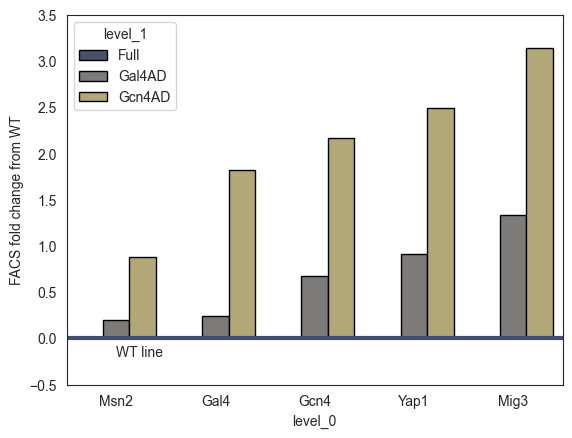

In [13]:
fig, ax = plt.subplots(1)
sns.barplot(data=data_plot, x='level_0', y=0, hue='level_1', palette=sns.color_palette('cividis', n_colors=3), ax=ax, edgecolor='k')
ax.set_ylim([-0.5,3.5])
ax.axhline(0, c=sns.color_palette('cividis', n_colors=3)[0], linewidth=3, markeredgecolor='r')
ax.set_ylabel('FACS fold change from WT')
ax.text(0,-.2,'WT line')
# fig.savefig('newtext_figs/fig3/fluor.pdf', bbox_inches = 'tight', transparent=True)

# Figure 3E

In [14]:
sc_colors = sns.color_palette('cividis', n_colors=3)
size=230
alpha=0.7
edges = 'k'

In [15]:
newdat = pd.read_pickle('../data/sumprom_20230328_last_one.gz').filter(regex='aro80')
newdat = newdat.drop('Msn2DBD_Gcn4AD_native_aro80_1', axis=1)
newdat.columns = [name[:-2] for name in newdat.columns.values]
newdat = newdat.transpose().reset_index().groupby('index').mean().transpose()
newdat.columns.name = None
newaro = newdat.loc[aro_targets].sum()
newdat = newdat.drop(aro_targets)
newdat = newdat.loc[bins.index[:-1].drop(['SPL2', 'NAF1', 'ESBP6', 'SDH6'])]

for i, typ in enumerate(['Full', 'Gal4AD', 'Gcn4AD']):

    t = rna_libs.filter(regex='Msn2').filter(regex=typ).sort_values(by='facs', axis=1).loc['facs']
    
    # print(t[-5:].mean())
natprommsn2 = [4.272,3.8705, 4.4178, 4.0759, 4.1303399999999995, 3.7812]

newdat.loc['facs', :] = natprommsn2

In [16]:
all_libs = data_check.filter(regex='facs').copy()
data = pd.read_pickle('../data/averaged_chec_sumprom.gz')
arosum_all = data.loc[aro_targets, all_libs.columns].sum()
all_libs.columns = ['_'.join(name.split('_')[:-4]) for name in all_libs.columns.values]
arosum_all.index = all_libs.columns
all_facs_libs = [float(name.split('_')[-2]) for name in all_libs.columns.values]
all_libs.loc['facs', :] = all_facs_libs

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

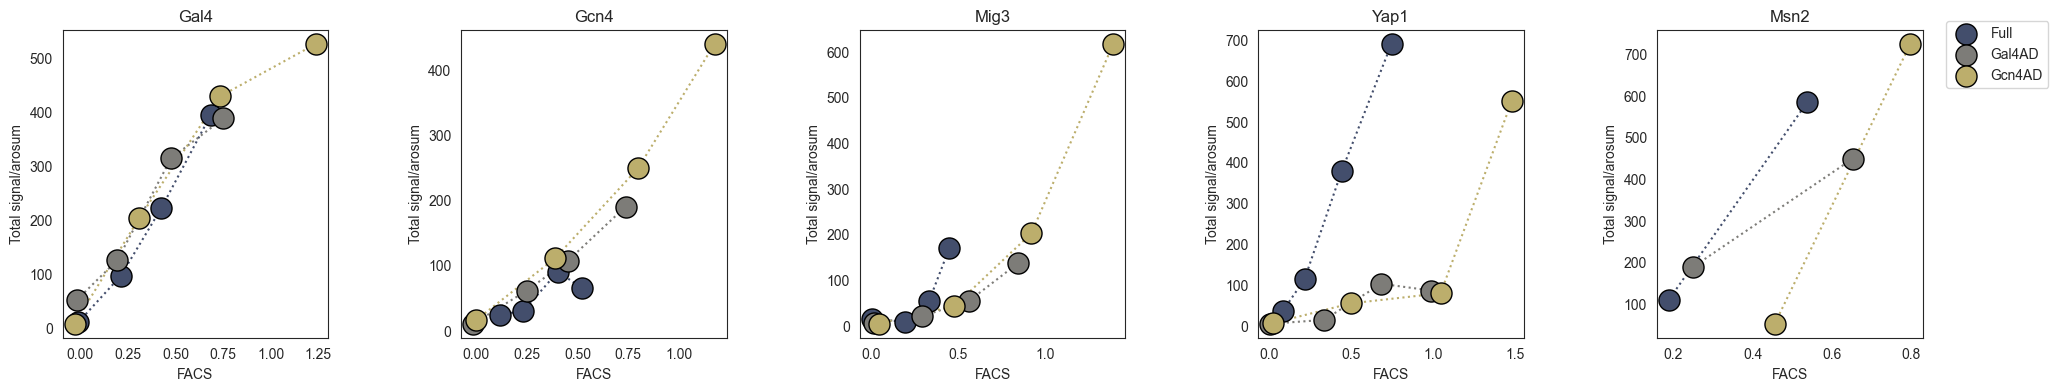

In [17]:
fig, ax = plt.subplots(1,5, figsize=(24,4))
ax=ax.flatten()
data=all_libs
for k, tf in enumerate(['Gal4', 'Gcn4', 'Mig3', 'Yap1']): 
    for i, typ in enumerate(['Full', 'Gal4AD', 'Gcn4AD']):
        curr_libs = data.filter(regex='^'+tf).filter(regex=typ).sort_values(by='facs', axis=1)
        norm_curr_libs = curr_libs.div(arosum_all.loc[curr_libs.columns], axis=1) 
        ax[k].scatter(curr_libs.loc['facs']-by_facs[tf][typ], norm_curr_libs.sum(),
                      c=sc_colors[i], edgecolors=edges, s=size, label=typ, zorder=20)
        ax[k].plot(curr_libs.loc['facs']-by_facs[tf][typ], norm_curr_libs.sum(),zorder=0,
                      c=sc_colors[i], linestyle=':')
        ax[k].set_xlabel('FACS')
        ax[k].set_ylabel('Total signal/arosum')
    ax[k].set_title(tf)
    
axi=ax[4]
for i, typ in enumerate(['Full', 'Gal4AD', 'Gcn4AD']):
    cd = newdat.filter(regex=typ)
    axi.scatter(cd.loc['facs',:]-by_facs['Msn2'][typ], cd.drop('facs').sum()/newaro.loc[cd.columns], s=size, edgecolors='k', zorder=20, c=sc_colors[i], label=typ)
    axi.plot(cd.loc['facs',:]-by_facs['Msn2'][typ], cd.drop('facs').sum()/newaro.loc[cd.columns], c=sc_colors[i], linestyle=':')
axi.set_title('Msn2')
axi.set_xlabel('FACS')
axi.set_ylabel('Total signal/arosum')



axi.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
fig.subplots_adjust(wspace=0.5,hspace=0.5)
# fig.savefig('newtext_figs/fig3/strengths.pdf', bbox_inches = 'tight', transparent=True)

# Figure 3D

In [18]:
perc_dict = dict()
for tf in TFS[:-2]:
    direct=directions[tf][0]
    if tf == 'Gal4':
        curr_bind = tfs_binding_deletions_tef.filter(regex='^{}'.format(tf)).iloc[:, [0,1,3,2]]
    else:
        curr_bind = tfs_binding_deletions_tef.filter(regex='^{}'.format(tf))
    perc_dict[tf] = curr_bind.loc[direct_targets[tf][direct]].sum().div(curr_bind.sum()).values

In [19]:
perc_df = pd.DataFrame(perc_dict, index=['Full_native', 'Full_tef', 'Gal4AD_tef', 'Gcn4AD_tef'])

Text(0.5, 1.0, 'Percenteage of signal on targets')

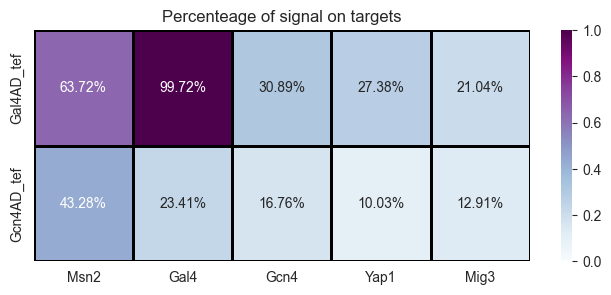

In [20]:
fig, ax = plt.subplots(1, figsize=(8,3))
palette = sns.blend_palette(('#F2F2F2', '#F2C185', '#D98C4A', '#734D2C', '#59321B'), as_cmap=True)

sns.heatmap(perc_df.iloc[1:,:].div(perc_df.iloc[1,:]).drop('Full_tef'), annot=True, fmt='.2%',
            cbar=True, cmap='BuPu', linecolor='k', linewidths=1, ax=ax, vmin=0, vmax=1)
ax.set_title('Percenteage of signal on targets')
# fig.savefig('newtext_figs/fig3/percofsignal.pdf', bbox_inches = 'tight', transparent=True)